# Preprocessing

In [1]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from itertools import chain
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed
from fixation3d import extract_fixations

In [2]:
import os
os.chdir("../data")

## Get data

In [ ]:
participant_paths = glob.glob("input/*")
participant_paths

['input/2024-08-14_14-28-31.746869 p01']

In [ ]:
participant_data = {}
for path in participant_paths:
    pid = int(path.split("_P")[-1])
    participant_data[pid] = {}
    participant_data[pid]["tag"] = pd.read_csv(os.path.join(path, "tag.csv"))
    participant_data[pid]["eye_ray"] = pd.read_csv(os.path.join(path, "hololens2_eye_ray.csv"))
    participant_data[pid]["hand_pose"] = pd.read_csv(os.path.join(path, "hololens2_hand_pose.csv"))
    participant_data[pid]["head_pose"] = pd.read_csv(os.path.join(path, "hololens2_head_pose.csv"))

# we have only 1 participant, so I won't bother with the loop
pid = 1

labels = participant_data[pid]["tag"]["label"].apply(lambda label: eval(label)["label"])
timestamps = pd.to_datetime(participant_data[pid]["tag"]["timestamp"], unit="ms")
participant_data[pid]["tag"]["label"] = labels
participant_data[pid]["tag"]["timestamp"] = timestamps
event_df = participant_data[pid]["tag"]

## Trial data

In [5]:
start_list = []
end_list = []
condition_list = []

is_trial = False
for index, (timestamp, solving) in event_df.iterrows():
    if is_trial:
        if solving == "stop":
            end_list.append(timestamp - pd.Timedelta(seconds=1))
            is_trial = False
            continue
        else:
            end_list.append(None)
            is_trial = False
    
    if solving in ("start", "other"):
        is_trial = True
        start_list.append(timestamp + pd.Timedelta(seconds=1))
        if solving == "start":
            condition_list.append("solving")
        if solving == "other":
            condition_list.append("scrambling")

trial_df = pd.DataFrame({
    "start": start_list,
    "end": end_list,
    "condition": condition_list
})
trial_df["solving"] = (trial_df["condition"] == "solving").astype(int)
trial_df["duration"] = (trial_df["end"] - trial_df["start"]).dt.total_seconds()
session_ids = [i for i in range(len(trial_df) // 2) for _ in range(2)]
trial_df.insert(0, "session_id", session_ids)
trial_df.head()

,session_id,start,end,condition,solving,duration
0,0,2024-08-14 12:29:01.251596924,2024-08-14 12:29:17.327259033,scrambling,0,16.075662
1,0,2024-08-14 12:29:28.837606934,2024-08-14 12:30:09.140559814,solving,1,40.302953
2,1,2024-08-14 12:30:17.916100098,2024-08-14 12:30:52.678635986,scrambling,0,34.762536
3,1,2024-08-14 12:30:59.908319092,2024-08-14 12:31:40.381931885,solving,1,40.473613
4,2,2024-08-14 12:32:20.391597900,2024-08-14 12:32:47.668445068,scrambling,0,27.276847


In [6]:
def fix_sensor_metadata(sensor):
    sensor_df = participant_data[pid][sensor].copy()
    sensor_df["timestamp"] = pd.to_datetime(sensor_df["timestamp"], unit="ms")
    sensor_df.insert(1, "session_id", np.nan)
    sensor_df.insert(2, "trial_id", np.nan)

    # we only have 1 participant, so we can define session_ids to split the data during training/testing
    for session_id in trial_df["session_id"].unique():
        for index, row in trial_df[trial_df["session_id"] == session_id].iterrows():
            sensor_df.loc[(sensor_df["timestamp"] >= row["start"]) & (sensor_df["timestamp"] <= row["end"]), "trial_id"] = index
            sensor_df.loc[(sensor_df["timestamp"] >= row["start"]) & (sensor_df["timestamp"] <= row["end"]), "session_id"] = session_id
    return sensor_df

eye_ray_df = fix_sensor_metadata("eye_ray")
hand_pose_df = fix_sensor_metadata("hand_pose")
head_pose_df = fix_sensor_metadata("head_pose")

In [7]:
solving_trials = trial_df[trial_df["condition"] == "solving"].index
scrambling_trials = trial_df[trial_df["condition"] == "scrambling"].index

In [8]:
trial_df.to_pickle("working/trial_df.pkl")

## Batches

Create batches using sliding windows on each of the trials.

We need:
- `batch_index`: with start and end times for all windows.
- `feature_df`: containing hand-crafted features of each batch. Ready for machine learning.
- `batch_data`: containing the data of each batch, separated by sensor. Ready for deep learning.

### Batch index

In [9]:
def generate_trial_windows(session_id, trial_id, window_size=10, step_size=1):
    trial_start = trial_df.loc[
        (trial_df["session_id"] == session_id) & (trial_df.index == trial_id), "start"
    ].values[0]
    trial_end = trial_df.loc[
        (trial_df["session_id"] == session_id) & (trial_df.index == trial_id), "end"
    ].values[0]
    current_time = trial_start
    while current_time + pd.Timedelta(seconds=window_size) <= trial_end:
        start_time, end_time = current_time, current_time + pd.Timedelta(seconds=window_size)
        yield (start_time, end_time)
        current_time += pd.Timedelta(seconds=step_size)
        
def generate_batch_index(trial_df, window_size, step_size):
    batches = []
    for session_id in trial_df["session_id"].unique():
        for trial_id in trial_df[trial_df["session_id"] == session_id].index:
            for start_time, end_time in generate_trial_windows(session_id, trial_id, window_size, step_size):
                solving = trial_df.loc[
                    (trial_df["session_id"] == session_id) & (trial_df.index == trial_id),
                    "solving",
                ].values[0]
                batches.append((session_id, trial_id, start_time, end_time, solving))
    batch_index = (
        pd.DataFrame(batches, columns=["session_id", "trial_id", "start_time", "end_time", "solving"])
        .reset_index()
        .rename(columns={"index": "batch_id"})
    )
    return batch_index

window_size = 10
step_size = 1
batch_index = generate_batch_index(trial_df, window_size, step_size)
batch_index.to_pickle("working/batch_index.pkl")
batch_index.sample(3)

,batch_id,session_id,trial_id,start_time,end_time,solving
403,403,7,14,2024-08-14 12:41:15.317007080,2024-08-14 12:41:25.317007080,0
227,227,4,9,2024-08-14 12:36:28.710139893,2024-08-14 12:36:38.710139893,1
441,441,7,15,2024-08-14 12:42:22.870928955,2024-08-14 12:42:32.870928955,1


### Helpful things for next steps

Things like list of sensors, relevant columns, etc.

In [10]:
sensor_list = ["gaze", "hand", "head"]
sample_rate_dict = {"gaze": 20, "fixation": 3, "hand": 20, "head": 20}
ignore_columns = ["session_id", "trial_id", "timestamp"]

sensor_data_dict = dict()
sensor_data_dict["gaze"] = eye_ray_df
sensor_data_dict["hand"] = hand_pose_df
sensor_data_dict["head"] = head_pose_df
feature_columns = dict()
for sensor in sensor_list:
    feature_columns[sensor] = list(sensor_data_dict[sensor].columns.difference(ignore_columns))

### Feature extraction

In [11]:
def summarize_features(sensor, window_df):
    features = dict()
    for column in window_df.columns:
        if window_df[column].isnull().sum() < len(window_df):
            features[f"{sensor}_{column}_median"] = window_df[column].median()
            features[f"{sensor}_{column}_std"] = window_df[column].std()
            features[f"{sensor}_{column}_min"] = window_df[column].min()
            features[f"{sensor}_{column}_max"] = window_df[column].max()
    return features

#### Eye tracking

In [12]:
def extract_gaze_features(gaze_df):
    gaze_df = gaze_df.rename(columns={"direction_x": "x", "direction_y": "y", "direction_z": "z"})
    fixation_df = extract_fixations(
        gaze_df,
        min_points_per_fixation=int(0.1 * sample_rate_dict["gaze"]),
        min_fixation_size=0.054 / 3 * 2, # 2 bits of the cube
        max_fixation_size=0.054, # 1 face of the cube
    )
    fixation_df["duration"] = (fixation_df["end"] - fixation_df["start"]).dt.total_seconds()
    fixation_df["distance"] = np.sqrt(fixation_df["x"].diff() ** 2 + fixation_df["y"].diff() ** 2 + fixation_df["z"].diff() ** 2)
    fixation_df["speed"] = fixation_df["distance"] / fixation_df["duration"]

    # angle between consecutive fixations
    vector_x = fixation_df["x"] - fixation_df["origin_x"]
    vector_y = fixation_df["y"] - fixation_df["origin_y"]
    vector_z = fixation_df["z"] - fixation_df["origin_z"]
    current_vector = np.stack([vector_x, vector_y, vector_z], axis=1)
    previous_vector = np.stack([vector_x.shift(1), vector_y.shift(1), vector_z.shift(1)], axis=1)
    dot_product = np.einsum('ij,ij->i', current_vector, previous_vector)
    norm_vector = np.linalg.norm(current_vector, axis=1)
    previous_norm_vector = np.linalg.norm(previous_vector, axis=1)
    fixation_df["angle"] = np.arccos(dot_product / (norm_vector * previous_norm_vector))

    fixation_df.drop(columns=["start", "end", "x", "y", "z", "origin_x", "origin_y", "origin_z"], inplace=True)
    fixation_features = summarize_features("fixation", fixation_df)
    return fixation_features

#### Hand pose


A hand pose is represented by a 14-dimensional vector, with 7 parameters for each hand: 
- 3 parameters encode the 3D position of the hand
- 4 parameters determine its orientation using unitary [quaternions](https://eater.net/quaternions). 

Each quaternion $q$ has a real component $q_w$, representing a rotation around an axis of rotation, represented by the imaginary components $q_x$, $q_y$ and $q_z$.

<!-- For the quaternion to be unitary, $\sqrt{q_x^2 + q_y^2 + q_z^2 + q_w^2} = 1$. We could transform the quaternions into a 3D vector and an angle of rotation in radians. The angle of rotation is determined by: 

$$2 \cdot acos(q_w)$$

To convert the components of the axis of rotation into a unitary 3D vector, we will use the formula:

$$\forall c \in \{x, y, z\}, \frac{q_c}{\sqrt{1 - q_w^2}}$$ 

A special case occurs in the absence of rotation. If this happens, read the rest of the paragraph and handle the special case. From the first formula, this would happen when $acos(q_w) = 0$, that is, when $q_w = 1$. To keep the quaternion unitary, the other components ($x, y, z$) must be zero, leading to a quaternion of the form $(1, 0, 0, 0)$. As the angle approaches zero, $\forall c \in \{x, y, z\}, q_c \to 0$, making our vector approach the origin. The problem arises when $q_w = 1$, because we would divide by 0, making our vector undefined. To avoid that, if the angle is zero, we will replace the vector with the origin $(0, 0, 0)$. -->

In [13]:
def extract_hand_features(hand_df):
    for hand in ["left", "right"]:
        quaternion_df = hand_df[
            [
                f"{hand}_orientation_x",
                f"{hand}_orientation_y",
                f"{hand}_orientation_z",
                f"{hand}_orientation_w",
            ]
        ]

        # angular distance
        dot_product = np.abs(
            np.nansum(
                quaternion_df.values * quaternion_df.shift(1).values,
                axis=1,
            )
        )  # absolute value to avoid wrap-around issues
        dot_product = np.clip(dot_product, 0, 1) # avoid numerical errors
        hand_df[f"{hand}_orientation_angular_distance"] = 2 * np.arccos(dot_product)
        hand_df[f"{hand}_position_change"] = np.linalg.norm(
            hand_df[[f"{hand}_position_x", f"{hand}_position_y", f"{hand}_position_z"]]
            .diff(axis=0)
            .values,
            axis=1,
        )
        drop_columns = [
            column for column in hand_df.columns
            if re.match(f"{hand}_(position|orientation)_[x|y|z|w]", column)
            or "accuracy" in column  # could be useful for combining deep learning models, but not for machine learning I think
        ]
        hand_df.drop(columns=drop_columns, inplace=True)
    hand_features = summarize_features("hand", hand_df.drop(columns=["timestamp"]))
    return hand_features

#### Head pose

The head pose is represented by a 9-dimensional vector: 
- 3D position of the head (`position_x`, `position_y`, `position_z`)
- Normalized 3D vector indicating forward direction (`forward_x`, `forward_y`, `forward_z`)
- Normalized 3D vector indicating upward direction (`up_x`, `up_y`, `up_z`)

In [14]:
def angular_distance_3d(direction_df):
    dot_product = np.nansum(
        direction_df.values * direction_df.shift(1).values,
        axis=1,
    )
    dot_product = np.clip(dot_product, -1, 1)
    angular_distances = np.arccos(dot_product)
    return angular_distances

def extract_head_features(head_df):
    head_df["position_change"] = np.linalg.norm(
        head_df[["position_x", "position_y", "position_z"]].diff(axis=0).values, axis=1
    )
    head_df["forward_angular_distance"] = angular_distance_3d(head_df[["forward_x", "forward_y", "forward_z"]])
    head_df["up_angular_distance"] = angular_distance_3d(head_df[["up_x", "up_y", "up_z"]])

    drop_columns = [
        column for column in head_df.columns
        if re.match(f"(position|forward|up)_[x|y|z]", column)
    ]
    head_df.drop(columns=drop_columns, inplace=True)
    head_features = summarize_features("head", head_df.drop(columns=["timestamp"]))
    return head_features

### Create feature_df

In [15]:
def extract_features(batch):
    query = "session_id == @batch['session_id'] and trial_id == @batch['trial_id'] and timestamp >= @batch['start_time'] and timestamp <= @batch['end_time']"
    feature_dict = dict()
    for sensor in sensor_list:
        sensor_df = (
            sensor_data_dict[sensor]
            .query(query)
            .drop(columns=["session_id", "trial_id"])
            .copy()
        ) 
        if sensor == "gaze":
            sensor_feature_dict = extract_gaze_features(sensor_df)
        elif sensor == "hand":
            sensor_feature_dict = extract_hand_features(sensor_df)
        elif sensor == "head":
            sensor_feature_dict = extract_head_features(sensor_df)
        feature_dict.update(sensor_feature_dict)
    
    return feature_dict

feature_df = pd.DataFrame([extract_features(batch) for _, batch in batch_index.iterrows()])  # 54.5 seconds
feature_df.to_pickle("working/feature_df.pkl")
feature_df.head()

,fixation_duration_median,fixation_duration_std,fixation_duration_min,fixation_duration_max,fixation_distance_median,fixation_distance_std,fixation_distance_min,fixation_distance_max,fixation_speed_median,fixation_speed_std,...,head_position_change_min,head_position_change_max,head_forward_angular_distance_median,head_forward_angular_distance_std,head_forward_angular_distance_min,head_forward_angular_distance_max,head_up_angular_distance_median,head_up_angular_distance_std,head_up_angular_distance_min,head_up_angular_distance_max
0,0.471093,0.339892,0.046771,1.085419,0.060262,0.027569,0.015302,0.090408,0.093115,0.215167,...,0.000091,0.003910,0.003641,0.107630,0.000434,1.570796,0.008459,0.107422,0.0,1.570796
1,0.471093,0.330523,0.046771,1.085419,0.060262,0.027569,0.015302,0.090408,0.093115,0.215167,...,0.000091,0.003007,0.003572,0.107388,0.000434,1.570796,0.008371,0.107177,0.0,1.570796
2,0.517980,0.350713,0.046490,1.085419,0.050179,0.024702,0.015302,0.076121,0.085037,0.191650,...,0.000091,0.002529,0.003449,0.107655,0.000434,1.570796,0.007817,0.107438,0.0,1.570796
3,0.565422,0.322124,0.046490,1.085419,0.047059,0.024737,0.015302,0.076121,0.085037,0.192079,...,0.000042,0.002226,0.003286,0.107662,0.000434,1.570796,0.008026,0.107432,0.0,1.570796
4,0.565156,0.274288,0.046490,0.942412,0.074279,0.022242,0.038143,0.078677,0.101193,0.067829,...,0.000042,0.003288,0.003327,0.107655,0.000434,1.570796,0.007883,0.107434,0.0,1.570796


### Batch data (deep learning)

#### Fit scalers using leave-one-out

These scalers will be used to normalize the data while ensuring separation of train and test data.

In [16]:
def leave_one_out_scalers(excluded_session_id):
    sensor_scaler_dict = dict()
    for sensor in sensor_list:
        X = (
            sensor_data_dict[sensor]
            .loc[
                sensor_data_dict[sensor]["session_id"] != excluded_session_id,
                feature_columns[sensor]
            ]
            .dropna()
            .values
        )
        scaler = StandardScaler().fit(X)
        sensor_scaler_dict[sensor] = scaler
    return sensor_scaler_dict

leave_out_session_scalers = dict()
for leave_out_session_id in trial_df["session_id"].unique():
    leave_out_session_scalers[leave_out_session_id] = leave_one_out_scalers(leave_out_session_id)

pickle.dump(leave_out_session_scalers, open("working/leave_one_out_scalers.pkl", "wb"))

In [22]:
def get_window_data(self, session_id, sample_rate_dict, sensor, trial_id, start_time, end_time):
    # resample
    # interpolate
    X = self.data_dict[sensor].loc[
        (self.data_dict[sensor]["session_id"] == session_id)
        & (self.data_dict[sensor]["trial_id"] == trial_id)
        & (self.data_dict[sensor]["timestamp"] >= start_time)
        & (self.data_dict[sensor]["timestamp"] < end_time),
        ["timestamp"] + feature_columns[sensor],
    ]
    expected_length = sample_rate_dict[sensor] * self.window_size
    X = X[:expected_length]
    X = X.drop(columns=["timestamp"]).values
    X = leave_out_session_scalers[session_id][sensor].transform(X)
    if np.isnan(X).any():
        print("NAN values found")
        X = np.nan_to_num(X, nan=0.0)
    X = np.pad(X, ((0, expected_length - X.shape[0]), (0, 0)), constant_values=0)
    X = np.expand_dims(X, axis=0)
    return X

In [10]:
identifier_columns = ["timestamp", "session_id", "trial_id"]

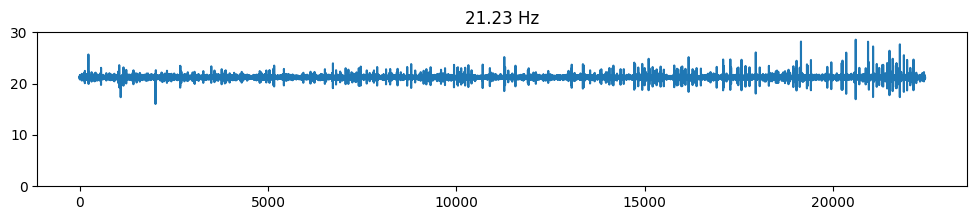

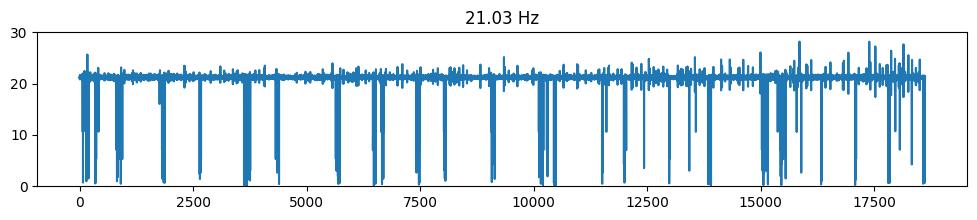

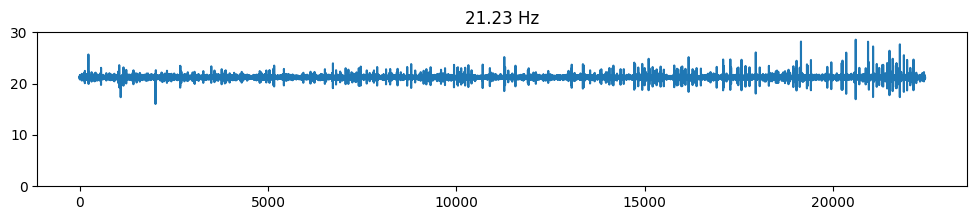

In [11]:
def plot_sample_rate(df):
    timestamp_in_ms = df['timestamp'].astype(int) / 10**6
    sample_rate = 1000 / np.array([timestamp_in_ms.iloc[i] - timestamp_in_ms.iloc[i - 1] for i in range(1, len(df))])
    plt.figure(figsize=(12, 2))
    plt.plot(sample_rate)
    plt.ylim(0, 30)
    plt.title(f"{np.mean(sample_rate):.2f} Hz")
    plt.show()

plot_sample_rate(eye_ray_df)
plot_sample_rate(hand_pose_df)
plot_sample_rate(head_pose_df)

Although the theoretical sample rate was 30 Hz, based on the data, it's more like 20 Hz.
Each dataset will be resampled and interpolated to 20 Hz.

In [12]:
sample_rate_dict = 20

In [14]:
def interpolate_dataframe(raw_df, ignore_columns=["session_id", "trial_id", "timestamp", "start", "end"]):
    feature_columns = [feature_column for feature_column in raw_df.columns if feature_column not in ignore_columns]
    interpolated_df = raw_df.copy()
    for feature_column in feature_columns:
        y = interpolated_df[feature_column]
        mask = ~np.isnan(y)
        if len(y[mask]) > 0:
            interpolated_y = np.interp(
                interpolated_df["timestamp"], interpolated_df["timestamp"][mask], y[mask]
            )
            interpolated_df[feature_column] = interpolated_y
    return interpolated_df

In [ ]:
def resample_dataframe(raw_df, sample_rate=20):
    resampled_df = raw_df.copy()
    period = pd.Timedelta(seconds=1 / sample_rate)
    # Round the timestamps to the nearest interval
    resampled_df["timestamp"] = resampled_df["timestamp"].dt.floor(period)
    start_time = resampled_df["timestamp"].iloc[0]
    end_time = resampled_df["timestamp"].iloc[-1]
    num_periods = int((end_time - start_time) / period) + 1
    theoretical_times = pd.date_range(
        start=start_time,
        periods=num_periods,
        freq=period
    )
    complete_df = (
        pd.DataFrame({"timestamp": theoretical_times})
        .merge(resampled_df, on="timestamp", how="left")
        .groupby("timestamp")
        .mean()
        .reset_index()
    )

    print(f"Resampled from {len(resampled_df)} to {len(complete_df)} rows")
    return complete_df

resample_dataframe(eye_ray_df).head()

### Eye tracking

In [37]:
eye_ray_df = resample_dataframe(eye_ray_df, sample_rate)

Resampled from 22443 to 21153 rows


In [48]:
fixation_df = extract_fixations(
    eye_ray_df.rename(
        columns={
              "direction_x": "x", "direction_y": "y", "direction_z": "z"
              }
    ),
    min_points_per_fixation=int(0.1 * sample_rate_dict),
    min_fixation_size=0.054 / 3 * 2, # 2 bits of the cube
    max_fixation_size=0.054, # 1 face of the cube
)
fixation_df.insert(0, "session_id", np.nan)
fixation_df.insert(1, "trial_id", np.nan)

for session_id in trial_df["session_id"].unique():
    for index, row in trial_df[trial_df["session_id"] == session_id].iterrows():
        fixation_df.loc[(fixation_df["start"] >= row["start"]) & (fixation_df["end"] <= row["end"]), "trial_id"] = index
        fixation_df.loc[(fixation_df["start"] >= row["start"]) & (fixation_df["end"] <= row["end"]), "session_id"] = session_id
fixation_df.head()

,session_id,trial_id,start,end,x,y,z,origin_x,origin_y,origin_z
0,NaN,NaN,2024-08-14 12:28:31.700,2024-08-14 12:28:32.050,-0.012077,-0.277806,-0.960462,-0.103872,0.007036,-0.261217
1,NaN,NaN,2024-08-14 12:28:32.150,2024-08-14 12:28:32.250,-0.275322,-0.082014,-0.957828,-0.093930,0.011127,-0.262677
2,NaN,NaN,2024-08-14 12:28:32.350,2024-08-14 12:28:32.500,-0.147442,-0.499240,-0.853814,-0.103529,0.008741,-0.255959
3,NaN,NaN,2024-08-14 12:28:32.700,2024-08-14 12:28:33.100,-0.340324,-0.463013,-0.818150,-0.104011,0.002346,-0.264965
4,NaN,NaN,2024-08-14 12:28:33.150,2024-08-14 12:28:33.350,-0.369839,-0.445797,-0.815149,-0.110238,0.003822,-0.261464


In [49]:
fixation_df["duration"] = (fixation_df["end"] - fixation_df["start"]).dt.total_seconds()
fixation_df["distance"] = np.sqrt(fixation_df["x"].diff() ** 2 + fixation_df["y"].diff() ** 2 + fixation_df["z"].diff() ** 2)
fixation_df["speed"] = fixation_df["distance"] / fixation_df["duration"]
fixation_df.head(3)

,session_id,trial_id,start,end,x,y,z,origin_x,origin_y,origin_z,duration,distance,speed
0,NaN,NaN,2024-08-14 12:28:31.700,2024-08-14 12:28:32.050,-0.012077,-0.277806,-0.960462,-0.103872,0.007036,-0.261217,0.35,NaN,NaN
1,NaN,NaN,2024-08-14 12:28:32.150,2024-08-14 12:28:32.250,-0.275322,-0.082014,-0.957828,-0.093930,0.011127,-0.262677,0.10,0.328084,3.280841
2,NaN,NaN,2024-08-14 12:28:32.350,2024-08-14 12:28:32.500,-0.147442,-0.499240,-0.853814,-0.103529,0.008741,-0.255959,0.15,0.448609,2.990725


In [50]:
def calculate_angles(vector_df):
    current_vector = np.array([vector_df[column].values for column in vector_df.columns]).T
    previous_vector = np.array([vector_df[column].shift(1).values for column in vector_df.columns]).T
    dot_product = np.einsum('ij,ij->i', current_vector, previous_vector)
    norm_vector = np.linalg.norm(current_vector, axis=1)
    previous_norm_vector = np.linalg.norm(previous_vector, axis=1)
    angle = np.arccos(dot_product / (norm_vector * previous_norm_vector))
    return angle

vector_x = fixation_df["x"] - fixation_df["origin_x"]
vector_y = fixation_df["y"] - fixation_df["origin_y"]
vector_z = fixation_df["z"] - fixation_df["origin_z"]
fixation_df["angle"] = calculate_angles(pd.DataFrame([vector_x, vector_y, vector_z], index=["x", "y", "z"]).T)
fixation_df.head(3)

,session_id,trial_id,start,end,x,y,z,origin_x,origin_y,origin_z,duration,distance,speed,angle
0,NaN,NaN,2024-08-14 12:28:31.700,2024-08-14 12:28:32.050,-0.012077,-0.277806,-0.960462,-0.103872,0.007036,-0.261217,0.35,NaN,NaN,NaN
1,NaN,NaN,2024-08-14 12:28:32.150,2024-08-14 12:28:32.250,-0.275322,-0.082014,-0.957828,-0.093930,0.011127,-0.262677,0.10,0.328084,3.280841,0.450794
2,NaN,NaN,2024-08-14 12:28:32.350,2024-08-14 12:28:32.500,-0.147442,-0.499240,-0.853814,-0.103529,0.008741,-0.255959,0.15,0.448609,2.990725,0.596651


In [51]:
fixation_df[["duration", "distance", "speed", "angle"]].corr()

,duration,distance,speed,angle
duration,1.000000,-0.202535,-0.311375,-0.202223
distance,-0.202535,1.000000,0.755728,0.997123
speed,-0.311375,0.755728,1.000000,0.751612
angle,-0.202223,0.997123,0.751612,1.000000


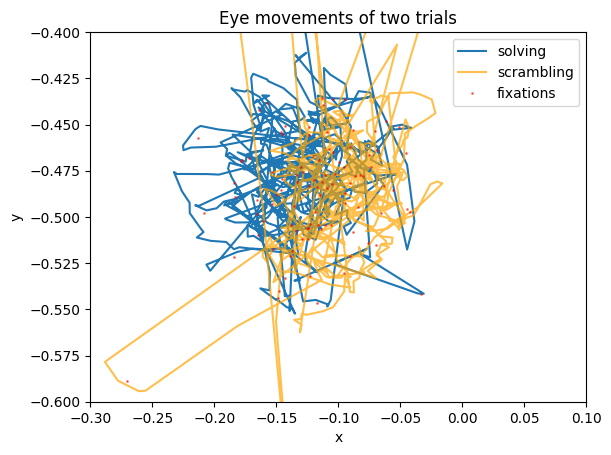

In [52]:
scrambling = eye_ray_df.loc[eye_ray_df["trial_id"] == 6, ["direction_x", "direction_y"]]
solving = eye_ray_df.loc[eye_ray_df["trial_id"] == 7, ["direction_x", "direction_y"]]
fixations = fixation_df.loc[fixation_df["trial_id"].isin([6, 7]), ["x", "y"]]
plt.plot(solving["direction_x"], solving["direction_y"])
plt.plot(scrambling["direction_x"], scrambling["direction_y"], color="orange", alpha=0.7)
plt.plot(fixations["x"], fixations["y"], "o", color="red", alpha=0.5, markersize=1)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(-0.3, 0.1)
plt.ylim(-0.6, -0.4)
plt.title("Eye movements of two trials")
plt.legend(["solving", "scrambling", "fixations"])

In [53]:
# make fixation_df compatible with the other sensor dataframes
fixation_df.insert(0, "timestamp", fixation_df["start"])
fixation_df.drop(columns=["start", "end", "origin_x", "origin_y", "origin_z"], inplace=True)
fixation_df.head(3)

,timestamp,session_id,trial_id,x,y,z,duration,distance,speed,angle
0,2024-08-14 12:28:31.700,NaN,NaN,-0.012077,-0.277806,-0.960462,0.35,NaN,NaN,NaN
1,2024-08-14 12:28:32.150,NaN,NaN,-0.275322,-0.082014,-0.957828,0.10,0.328084,3.280841,0.450794
2,2024-08-14 12:28:32.350,NaN,NaN,-0.147442,-0.499240,-0.853814,0.15,0.448609,2.990725,0.596651


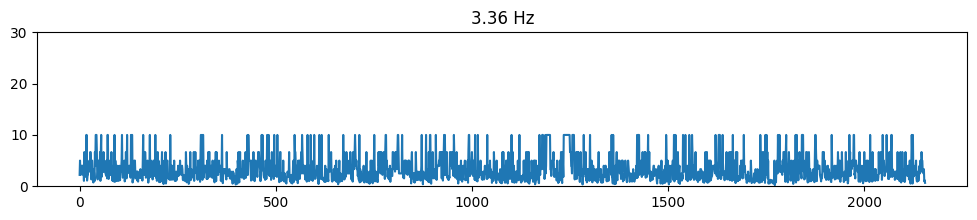

In [54]:
plot_sample_rate(fixation_df)

In [55]:
fixation_df = resample_dataframe(fixation_df, 3, interpolate=False)

Resampled from 2157 to 3172 rows


In [56]:
eye_ray_df = eye_ray_df[eye_ray_df["trial_id"].notnull()].reset_index(drop=True)
eye_ray_df.to_pickle("working/eye_ray_df.pkl")
fixation_df = fixation_df[fixation_df["trial_id"].notnull()].reset_index(drop=True)
fixation_df.to_pickle("working/fixation_df.pkl")

### Hand pose


A hand pose is represented by a 14-dimensional vector, with 7 parameters for each hand: 
- 3 parameters encode the 3D position of the hand
- 4 parameters determine its orientation using unitary [quaternions](https://eater.net/quaternions). 

Each quaternion $q$ has a real component $q_w$, representing a rotation around an axis of rotation, represented by the imaginary components $q_x$, $q_y$ and $q_z$.

<!-- For the quaternion to be unitary, $\sqrt{q_x^2 + q_y^2 + q_z^2 + q_w^2} = 1$. We could transform the quaternions into a 3D vector and an angle of rotation in radians. The angle of rotation is determined by: 

$$2 \cdot acos(q_w)$$

To convert the components of the axis of rotation into a unitary 3D vector, we will use the formula:

$$\forall c \in \{x, y, z\}, \frac{q_c}{\sqrt{1 - q_w^2}}$$ 

A special case occurs in the absence of rotation. If this happens, read the rest of the paragraph and handle the special case. From the first formula, this would happen when $acos(q_w) = 0$, that is, when $q_w = 1$. To keep the quaternion unitary, the other components ($x, y, z$) must be zero, leading to a quaternion of the form $(1, 0, 0, 0)$. As the angle approaches zero, $\forall c \in \{x, y, z\}, q_c \to 0$, making our vector approach the origin. The problem arises when $q_w = 1$, because we would divide by 0, making our vector undefined. To avoid that, if the angle is zero, we will replace the vector with the origin $(0, 0, 0)$. -->

In [60]:
hand_pose_df = resample_dataframe(hand_pose_df, sample_rate_dict)  # in the future we could try without interpolation

Resampled from 18623 to 21068 rows


In [61]:
def angular_distance(quaternion_df):
    dot_product = np.abs(
        np.nansum(
            quaternion_df.values * quaternion_df.shift(1).values,
            axis=1,
        )
    )  # absolute value to avoid wrap-around issues
    dot_product = np.clip(dot_product, 0, 1) # avoid numerical errors
    angular_distances = 2 * np.arccos(dot_product)

    return angular_distances

for hand in ["left", "right"]:
    quaternion_df = hand_pose_df[
        [
            f"{hand}_orientation_x",
            f"{hand}_orientation_y",
            f"{hand}_orientation_z",
            f"{hand}_orientation_w",
        ]
    ]
    hand_pose_df[f"{hand}_orientation_angular_distance"] = angular_distance(
        quaternion_df
    )
    hand_pose_df[f"{hand}_position_change"] = np.linalg.norm(
        hand_pose_df[[f"{hand}_position_x", f"{hand}_position_y", f"{hand}_position_z"]]
        .diff(axis=0)
        .values,
        axis=1,
    )

In [62]:
hand_pose_df = hand_pose_df[hand_pose_df["trial_id"].notnull()].reset_index(drop=True)
hand_pose_df.to_pickle("working/hand_pose_df.pkl")

### Head pose

The head pose is represented by a 9-dimensional vector: 
- 3D position of the head (`position_x`, `position_y`, `position_z`)
- Normalized 3D vector indicating forward direction (`forward_x`, `forward_y`, `forward_z`)
- Normalized 3D vector indicating upward direction (`up_x`, `up_y`, `up_z`)

In [63]:
head_pose_df = resample_dataframe(head_pose_df, sample_rate_dict)

Resampled from 22443 to 21153 rows


In [64]:
def angular_distance_3d(direction_df):
    dot_product = np.nansum(
        direction_df.values * direction_df.shift(1).values,
        axis=1,
    )
    dot_product = np.clip(dot_product, -1, 1)
    angular_distances = np.arccos(dot_product)

    return angular_distances

head_pose_df["position_change"] = np.linalg.norm(
    head_pose_df[["position_x", "position_y", "position_z"]].diff(axis=0).values, axis=1
)
head_pose_df["forward_angular_distance"] = angular_distance_3d(head_pose_df[["forward_x", "forward_y", "forward_z"]])
head_pose_df["up_angular_distance"] = angular_distance_3d(head_pose_df[["up_x", "up_y", "up_z"]])

In [65]:
head_pose_df = head_pose_df[head_pose_df["trial_id"].notnull()].reset_index(drop=True)
head_pose_df.to_pickle("working/head_pose_df.pkl")